In [6]:
import torch
import torch.nn. functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
# read in all the words:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set((''.join(words)))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi)


In [15]:
# important -> shuffle up the words:
import random
random.seed(42)
random.shuffle(words)

In [16]:
# build the dataset:
block_size = 8 # context length -> how many chars do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    return torch.tensor(X), torch.tensor(Y)

n1 = int(0.8*len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1]) # 80%
Xdev, Ydev = build_dataset(words[n1:n2]) # 10%
Xte, Yte = build_dataset(words[n2:]) # 10%

In [17]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> y
.......y ---> u
......yu ---> h
.....yuh ---> e
....yuhe ---> n
...yuhen ---> g
..yuheng ---> .
........ ---> d
.......d ---> i
......di ---> o
.....dio ---> n
....dion ---> d
...diond ---> r
..diondr ---> e
.diondre ---> .
........ ---> x
.......x ---> a
......xa ---> v
.....xav ---> i
....xavi ---> e


In [20]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # kaiming init
        self.bias = torch.randn(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return ([self.weight] + ([] if self.bias is None else [self.bias]))
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop):
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update'):
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass:
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch var
        else:
            xmean = self.running_mean
            xvar = self.running_var
        # normalize to unit variance:
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma + xhat + self.beta
        # update the buffers:
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return [] # there are no train-able parameters

class Embedding:

    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters(self):
        return [self.weight]
    
class FlattenConsecutive:

    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape # batch_size, time(tokens), channels(embedding dimension)
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters(self):
        return [] # there are no train-able parameters
    
class Sequential:

    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [21]:
n_embd = 24 # the dimensions of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2), Linear(n_embd*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    model.layers[-1].weight *= 0.1 # make the last layer less confident

parameters = model.parameters()
print(sum.pnelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

<generator object <genexpr> at 0x116001d80>


In [22]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # construct mini-batch:
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass:
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()

    # update: simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats:
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

      0/ 200000: 3.7562
  10000/ 200000: 1.6817
  20000/ 200000: 2.0877
  30000/ 200000: 2.0129
  40000/ 200000: 2.2027
  50000/ 200000: 1.8319
  60000/ 200000: 2.1380
  70000/ 200000: 2.0329
  80000/ 200000: 1.5326
  90000/ 200000: 1.5307
 100000/ 200000: 1.8413
 110000/ 200000: 1.9903
 120000/ 200000: 1.8784
 130000/ 200000: 2.0790
 140000/ 200000: 2.0814
 150000/ 200000: 1.6877
 160000/ 200000: 1.5769
 170000/ 200000: 2.5675
 180000/ 200000: 2.0992
 190000/ 200000: 2.2586


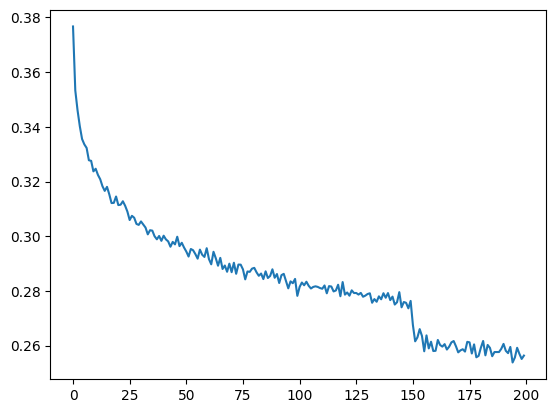

In [23]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [24]:
# put layers in eval mode (especially needed for batch-norm):
for layer in model.layers:
    layer.training = False

In [25]:
# evaluate the loss:
@torch.no_grad() # disable gradient tracking inside pytorch
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split,loss.item())

split_loss('train')
split_loss('val') # to check if the model is over-fitting


train 1.778077483177185
val 1.9784674644470215


In [26]:
# sample from the model:
with torch.no_grad():
    for _ in range(25):

        out = []
        context = [0] * block_size
        while True:
            # forward pass
            logits = model(torch.tensor([context])) # (1, block_size) ---> its like we are giving the model 1 batch
            probs = F.softmax(logits, dim=1)
            # sample from the distribution:
            ix = torch.multinomial(probs, num_samples=1).item()
            # shift the context window and track the samples:
            context = context[1:] + [ix]
            out.append(ix)
            # break when we reach '.' --->
            if ix == 0:
                break

        print(''.join(itos[i] for i in out)) # decode and print the generated name
        

anaisa.
dilfon.
loryah.
serana.
derix.
sulani.
ace.
hutia.
corrin.
jenilla.
adrianna.
remington.
mirrae.
kelle.
mun.
rayna.
ell.
savana.
mahil.
jharleste.
summingel.
analiksa.
tamorah.
zinace.
manoletteo.
